In [1]:
import oracledb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.font_manager as fm
from scipy import stats
from scipy.stats import shapiro, probplot

In [2]:
dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
connection = oracledb.connect(user="ora_acorni02", password="a91950360", dsn=dsn)

#test to make sure its connected
cur = connection.cursor()
for row in cur.execute("select * from HealthExpenditures"):
    print(row)
cur.close()

(1, 2009, 'F', 'middle-age', 6648365793, 43057)
(2, 2009, 'F', 'minor', 1304204278, 24387)
(3, 2009, 'F', 'senior', 6341276122, 138183)
(4, 2009, 'M', 'middle-age', 5643496801, 36890)
(5, 2009, 'M', 'minor', 1450135284, 26515)
(6, 2009, 'M', 'senior', 5119577611, 139461)
(7, 2010, 'F', 'middle-age', 6970375993, 44484)
(8, 2010, 'F', 'minor', 1360206902, 26078)
(9, 2010, 'F', 'senior', 6625478434, 139156)
(10, 2010, 'M', 'middle-age', 5935962238, 38110)
(11, 2010, 'M', 'minor', 1483186140, 27375)
(12, 2010, 'M', 'senior', 5568838890, 145478)
(13, 2011, 'F', 'middle-age', 7061430786, 44593)
(14, 2011, 'F', 'minor', 1339100731, 25455)
(15, 2011, 'F', 'senior', 7313125214, 152740)
(16, 2011, 'M', 'middle-age', 6070766215, 38567)
(17, 2011, 'M', 'minor', 1440814316, 26537)
(18, 2011, 'M', 'senior', 5965891757, 154568)
(19, 2012, 'F', 'middle-age', 7290461250, 45308)
(20, 2012, 'F', 'minor', 1373146085, 25858)
(21, 2012, 'F', 'senior', 8068418362, 168025)
(22, 2012, 'M', 'middle-age', 628833

In [3]:
sql = """
SELECT year, avg_expenditure_per_capita, median_wait_time
FROM AvgHealthExp_SurgWait
WHERE year > 2008 
AND year < 2023
"""

df = pd.read_sql(sql, con=connection)
df.head()

/tmp/ipykernel_1007/3790538004.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=connection)


,YEAR,AVG_EXPENDITURE_PER_CAPITA,MEDIAN_WAIT_TIME
0,2009,68082.166667,5.3
1,2011,73743.333333,5.7
2,2014,80580.500000,6.4
3,2010,70113.500000,5.9
4,2012,78586.666667,5.4


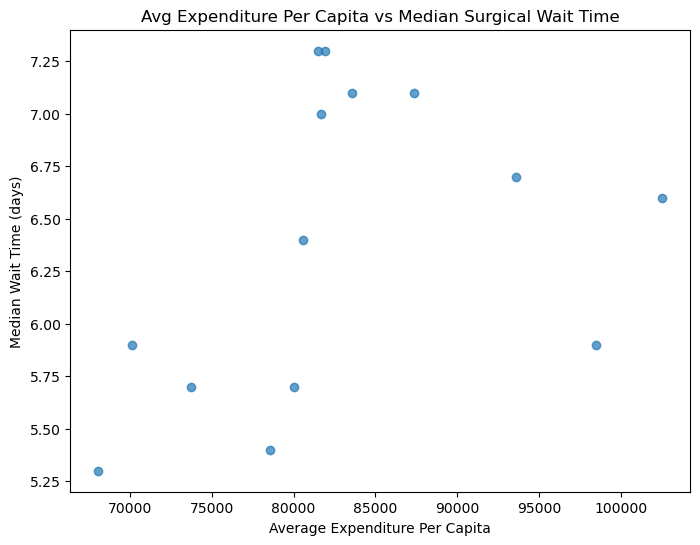

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(df['AVG_EXPENDITURE_PER_CAPITA'], df['MEDIAN_WAIT_TIME'], alpha=0.7)

# Adding labels and title
plt.title('Avg Expenditure Per Capita vs Median Surgical Wait Time')
plt.xlabel('Average Expenditure Per Capita')
plt.ylabel('Median Wait Time (days)')

# Show plot
plt.show()

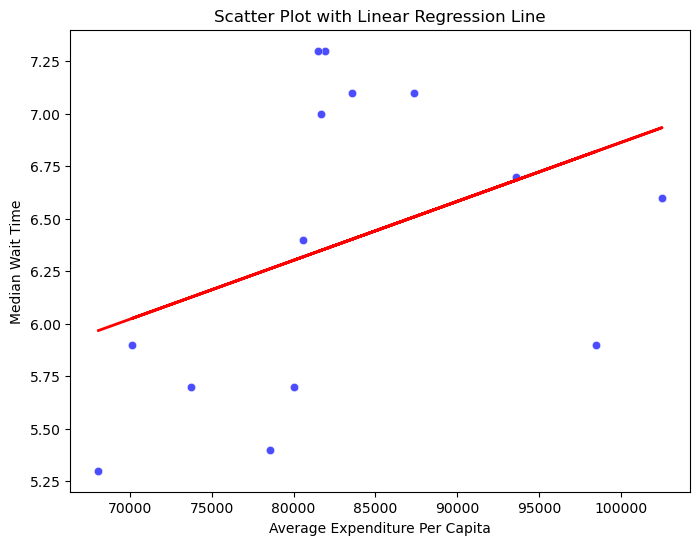

In [5]:
X = df[['AVG_EXPENDITURE_PER_CAPITA']].values  # Predictor (independent variable)
y = df['MEDIAN_WAIT_TIME'].values  # Response (dependent variable)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Get the regression line's predictions
y_pred = model.predict(X)

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AVG_EXPENDITURE_PER_CAPITA', y='MEDIAN_WAIT_TIME', data=df, color='blue', alpha=0.7)

# Plot the regression line
plt.plot(df['AVG_EXPENDITURE_PER_CAPITA'], y_pred, color='red', linewidth=2)

# Add title and labels
plt.title('Scatter Plot with Linear Regression Line')
plt.xlabel('Average Expenditure Per Capita')
plt.ylabel('Median Wait Time')

# Show plot
plt.show()

In [6]:
# Add a constant to the predictor (intercept term) for statsmodels
X = sm.add_constant(X)

# Fit the linear regression model using statsmodels
sm_model = sm.OLS(y, X).fit()

# Print the regression summary
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     2.067
Date:                Tue, 08 Apr 2025   Prob (F-statistic):              0.176
Time:                        12:51:42   Log-Likelihood:                -13.674
No. Observations:                  14   AIC:                             31.35
Df Residuals:                      12   BIC:                             32.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0571      1.630      2.489      0.0

/opt/conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [7]:
# Calculate residuals
residuals = y - y_pred

# Using to check if the residuals are normally distributed, since there are so few data points.
# The residual p-value is > 0.05 so we fail to reject the null hypothesis and the residuals are 
# normally distributed, meeting the necessary assumptions for linear regression
stat, p = shapiro(residuals)
print(f'Shapiro-Wilk p-value (residuals): {p}')

Shapiro-Wilk p-value (residuals): 0.21981488131191462


In [8]:
X = df['AVG_EXPENDITURE_PER_CAPITA'].values.flatten() 

# Add the quadratic term and constant (intercept)
X_quad = pd.DataFrame({
    'const': 1,  
    'x1': X,
    'x2': X**2  
})

# Fit the model
model = sm.OLS(y, X_quad).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     4.293
Date:                Tue, 08 Apr 2025   Prob (F-statistic):             0.0419
Time:                        12:51:42   Log-Likelihood:                -10.748
No. Observations:                  14   AIC:                             27.50
Df Residuals:                      11   BIC:                             29.41
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.4601     10.770     -1.993      0.0

/opt/conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


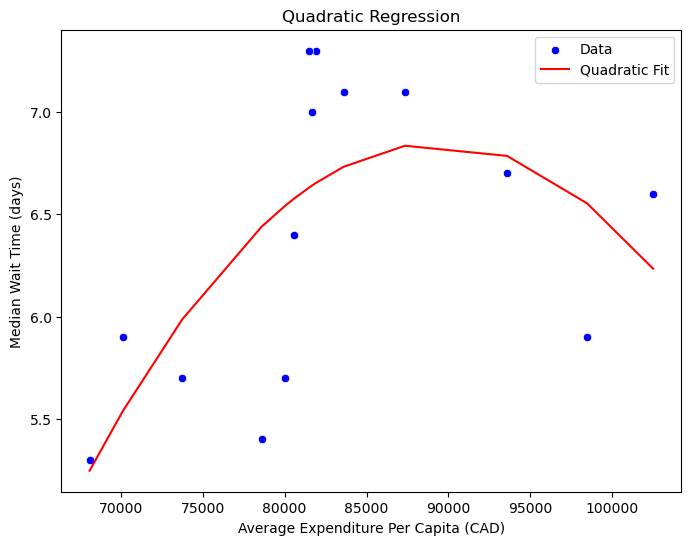

In [9]:
X_sorted = np.sort(X)
X_quad_sorted = pd.DataFrame({
    'const': 1,
    'x1': X_sorted,
    'x2': X_sorted**2
})

# Predict using the model
y_pred = model.predict(X_quad_sorted)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X, y=y, color='blue', label='Data')
plt.plot(X_sorted, y_pred, color='red', label='Quadratic Fit')
plt.xlabel('Average Expenditure Per Capita (CAD)')
plt.ylabel('Median Wait Time (days)')
plt.title('Quadratic Regression')
plt.legend()
plt.show()

In [10]:
sql = """
SELECT year, avg_expenditure_per_capita, long_wait_time
FROM AvgHealthExp_SurgWait
WHERE year > 2008
AND year < 2023
"""

df = pd.read_sql(sql, con=connection)
df.head()

/tmp/ipykernel_1007/465548682.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=connection)


,YEAR,AVG_EXPENDITURE_PER_CAPITA,LONG_WAIT_TIME
0,2009,68082.166667,24.3
1,2011,73743.333333,26.3
2,2014,80580.500000,30.9
3,2010,70113.500000,25.9
4,2012,78586.666667,26.0


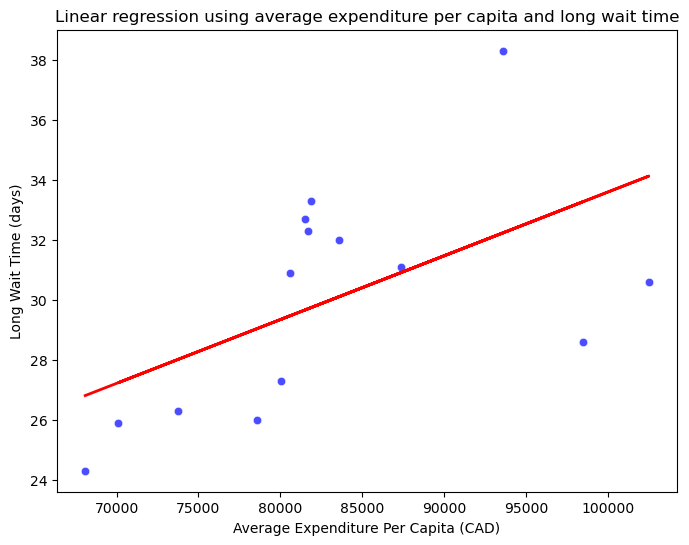

In [11]:
X = df[['AVG_EXPENDITURE_PER_CAPITA']].values  # Predictor (independent variable)
y = df['LONG_WAIT_TIME'].values  # Response (dependent variable)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Get the regression line's predictions
y_pred = model.predict(X)

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AVG_EXPENDITURE_PER_CAPITA', y='LONG_WAIT_TIME', data=df, color='blue', alpha=0.7)

# Plot the regression line
plt.plot(df['AVG_EXPENDITURE_PER_CAPITA'], y_pred, color='red', linewidth=2)

# Add title and labels
plt.title('Linear regression using average expenditure per capita and long wait time')
plt.xlabel('Average Expenditure Per Capita (CAD)')
plt.ylabel('Long Wait Time (days)')

# Show plot
plt.show()

In [12]:
# Add a constant to the predictor (intercept term) for statsmodels
X = sm.add_constant(X)

# Fit the linear regression model using statsmodels
sm_model = sm.OLS(y, X).fit()

# Print the regression summary
print(sm_model.summary())

## Higher adjusted r-squared than the linear regression with median wait times,
# though smaller than the quadratic regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     5.277
Date:                Tue, 08 Apr 2025   Prob (F-statistic):             0.0404
Time:                        12:51:42   Log-Likelihood:                -35.457
No. Observations:                  14   AIC:                             74.91
Df Residuals:                      12   BIC:                             76.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3389      7.726      1.597      0.1

/opt/conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [13]:
X = df['AVG_EXPENDITURE_PER_CAPITA'].values.flatten() 

# Add the quadratic term and constant (intercept)
X_quad = pd.DataFrame({
    'const': 1,  
    'x1': X,
    'x2': X**2  
})

# Fit the model
model = sm.OLS(y, X_quad).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     7.085
Date:                Tue, 08 Apr 2025   Prob (F-statistic):             0.0105
Time:                        12:51:42   Log-Likelihood:                -32.214
No. Observations:                  14   AIC:                             70.43
Df Residuals:                      11   BIC:                             72.34
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -113.6627     49.899     -2.278      0.0

/opt/conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


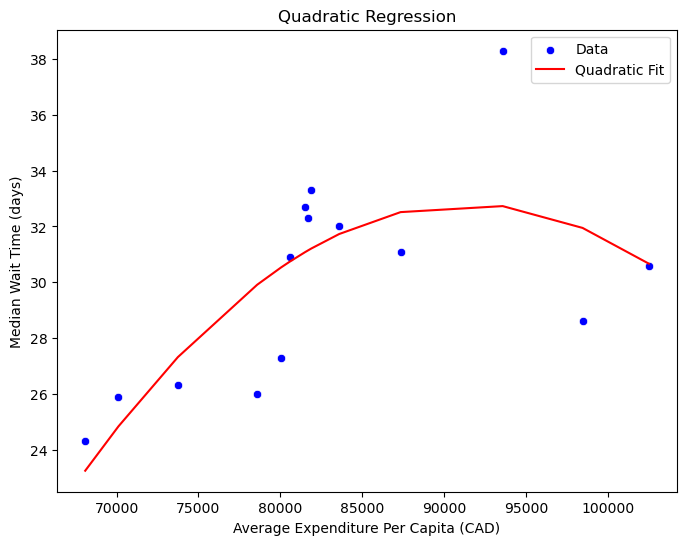

In [14]:
X_sorted = np.sort(X)
X_quad_sorted = pd.DataFrame({
    'const': 1,
    'x1': X_sorted,
    'x2': X_sorted**2
})

# Predict using the model
y_pred = model.predict(X_quad_sorted)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X, y=y, color='blue', label='Data')
plt.plot(X_sorted, y_pred, color='red', label='Quadratic Fit')
plt.xlabel('Average Expenditure Per Capita (CAD)')
plt.ylabel('Median Wait Time (days)')
plt.title('Quadratic Regression')
plt.legend()
plt.show()

In [15]:
sql = """
SELECT year, avg_total_expenditure, median_wait_time
FROM AvgHealthExp_SurgWait
WHERE year > 2008
AND year < 2023
"""

df = pd.read_sql(sql, con=connection)
df.head()

/tmp/ipykernel_1007/2555989532.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=connection)


,YEAR,AVG_TOTAL_EXPENDITURE,MEDIAN_WAIT_TIME
0,2009,4.417843e+09,5.3
1,2011,4.865188e+09,5.7
2,2014,5.479251e+09,6.4
3,2010,4.657341e+09,5.9
4,2012,5.162527e+09,5.4


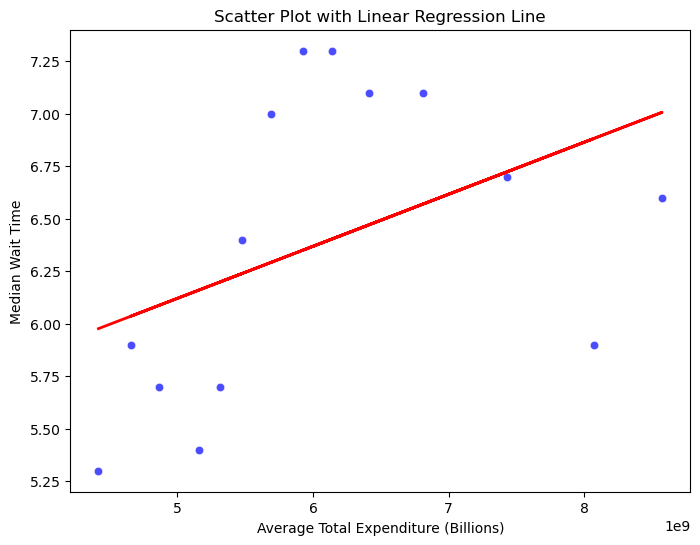

In [16]:
X = df[['AVG_TOTAL_EXPENDITURE']].values  # Predictor (independent variable)
y = df['MEDIAN_WAIT_TIME'].values  # Response (dependent variable)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Get the regression line's predictions
y_pred = model.predict(X)

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AVG_TOTAL_EXPENDITURE', y='MEDIAN_WAIT_TIME', data=df, color='blue', alpha=0.7)

# Plot the regression line
plt.plot(df['AVG_TOTAL_EXPENDITURE'], y_pred, color='red', linewidth=2)

# Add title and labels
plt.title('Scatter Plot with Linear Regression Line')
plt.xlabel('Average Total Expenditure (Billions)')
plt.ylabel('Median Wait Time')

# Show plot
plt.show()

In [17]:
# Add a constant to the predictor (intercept term) for statsmodels
X = sm.add_constant(X)

# Fit the linear regression model using statsmodels
sm_model = sm.OLS(y, X).fit()

# Print the regression summary
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     2.802
Date:                Tue, 08 Apr 2025   Prob (F-statistic):              0.120
Time:                        12:51:43   Log-Likelihood:                -13.318
No. Observations:                  14   AIC:                             30.64
Df Residuals:                      12   BIC:                             31.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8814      0.917      5.324      0.0

/opt/conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [18]:
X = df['AVG_TOTAL_EXPENDITURE'].values.flatten() 

# Add the quadratic term
X_quad = pd.DataFrame({
    'const': np.ones(len(X)),
    'x1': X,
    'x2': X**2  # Quadratic term
})

# Fit the model
model = sm.OLS(y, X_quad).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     10.78
Date:                Tue, 08 Apr 2025   Prob (F-statistic):            0.00653
Time:                        12:51:43   Log-Likelihood:                -10.299
No. Observations:                  14   AIC:                             24.60
Df Residuals:                      12   BIC:                             25.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.91e-19   3.85e-20     15.350      0.0

/opt/conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


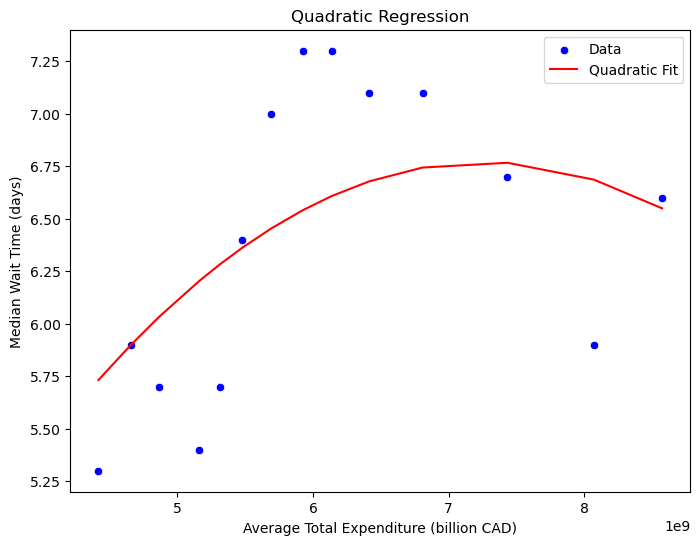

In [19]:
X_sorted = np.sort(X)
X_quad_sorted = pd.DataFrame({
    'const': 1,
    'x1': X_sorted,
    'x2': X_sorted**2
})

# Predict using the model
y_pred = model.predict(X_quad_sorted)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X, y=y, color='blue', label='Data')
plt.plot(X_sorted, y_pred, color='red', label='Quadratic Fit')
plt.xlabel('Average Total Expenditure (billion CAD)')
plt.ylabel('Median Wait Time (days)')
plt.title('Quadratic Regression')
plt.legend()
plt.show()

In [20]:
y_pred_quad = model.predict(X_quad)

residuals_quad = y - y_pred_quad

stat_quad, p_quad = shapiro(residuals_quad)
print(f'Shapiro-Wilk p-value (quadratic regression residuals): {p_quad}')

Shapiro-Wilk p-value (quadratic regression residuals): 0.5090792024915904


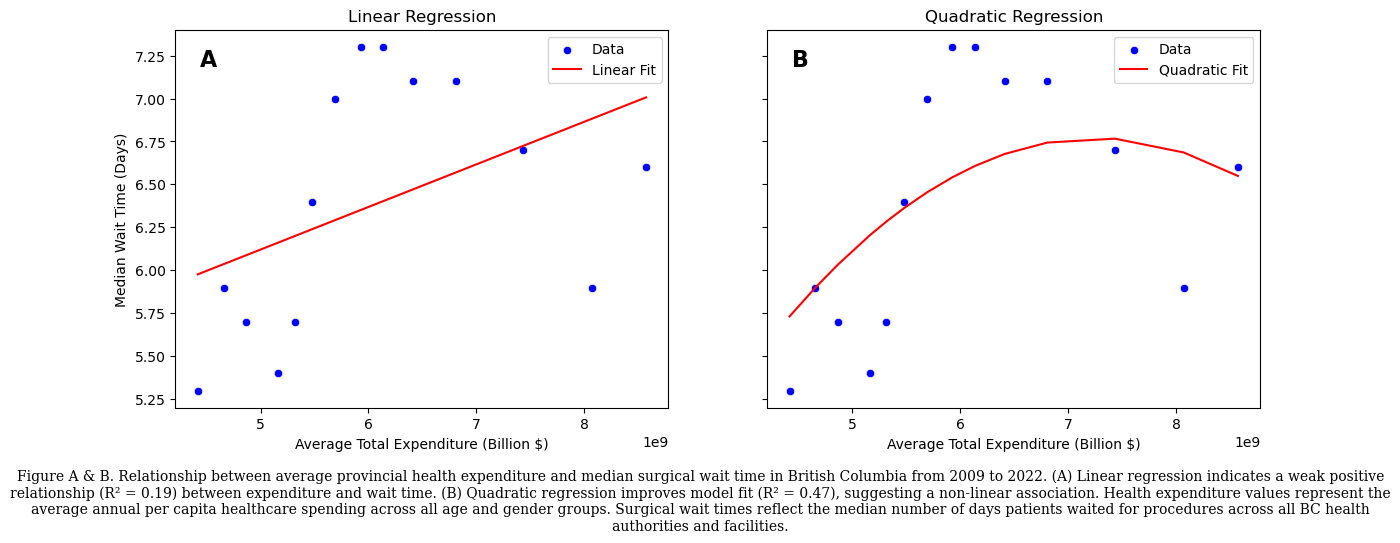

In [21]:
X = df['AVG_TOTAL_EXPENDITURE'].values
y = df['MEDIAN_WAIT_TIME'].values

# Sort X for smooth curve
X_sorted = np.sort(X)

# === LINEAR REGRESSION ===
X_linear = sm.add_constant(X)
model_linear = sm.OLS(y, X_linear).fit()
# Predict using sorted X
X_linear_sorted = sm.add_constant(X_sorted)
y_linear_pred = model_linear.predict(X_linear_sorted)

# === QUADRATIC REGRESSION ===
X_quad = pd.DataFrame({
    'const': 1,
    'x1': X,
    'x2': X**2
})
model_quad = sm.OLS(y, X_quad).fit()

# Predict using sorted X
X_quad_sorted = pd.DataFrame({
    'const': 1,
    'x1': X_sorted,
    'x2': X_sorted**2
})
y_quad_pred = model_quad.predict(X_quad_sorted)

# === MULTIFIGURE PLOT ===
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Linear Plot
sns.scatterplot(x=X, y=y, color='blue', ax=axs[0], label='Data')
axs[0].plot(X_sorted, y_linear_pred, color='red', label='Linear Fit')
axs[0].set_title('Linear Regression')
axs[0].set_xlabel('Average Total Expenditure (Billion $)')
axs[0].set_ylabel('Median Wait Time (Days)')
axs[0].legend()
axs[0].text(0.05, 0.95, 'A', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

# Quadratic Plot
sns.scatterplot(x=X, y=y, color='blue', ax=axs[1], label='Data')
axs[1].plot(X_sorted, y_quad_pred, color='red', label='Quadratic Fit')
axs[1].set_title('Quadratic Regression')
axs[1].set_xlabel('Average Total Expenditure (Billion $)')
axs[1].legend()
axs[1].text(0.05, 0.95, 'B', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

caption = (
    "Figure A & B. Relationship between average provincial health expenditure and median surgical wait time in British Columbia from 2009 to 2022. "
    "(A) Linear regression indicates a weak positive relationship (R² = 0.19) between expenditure and wait time. "
    "(B) Quadratic regression improves model fit (R² = 0.47), suggesting a non-linear association. "
    "Health expenditure values represent the average annual per capita healthcare spending across all age and gender groups. "
   "Surgical wait times reflect the median number of days patients waited for procedures across all BC health authorities and facilities."
)

fig.subplots_adjust(bottom=0.25)  # Add space at bottom for caption
caption_font = fm.FontProperties(family='serif', size=10)
plt.figtext(0.5, 0.05, caption, wrap=True, ha='center', fontsize=10, fontproperties=caption_font)

plt.show()

plt.show()

In [22]:
sql = """
SELECT year, avg_total_expenditure, long_wait_time
FROM AvgHealthExp_SurgWait
WHERE year > 2008
AND year < 2023
"""

df = pd.read_sql(sql, con=connection)
df.head()

/tmp/ipykernel_1007/3643653579.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=connection)


,YEAR,AVG_TOTAL_EXPENDITURE,LONG_WAIT_TIME
0,2009,4.417843e+09,24.3
1,2011,4.865188e+09,26.3
2,2014,5.479251e+09,30.9
3,2010,4.657341e+09,25.9
4,2012,5.162527e+09,26.0


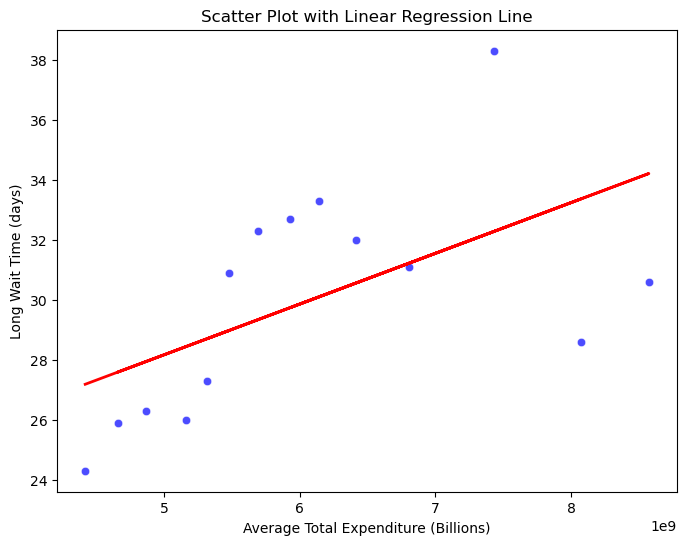

In [23]:
X = df[['AVG_TOTAL_EXPENDITURE']].values  # Predictor (independent variable)
y = df['LONG_WAIT_TIME'].values  # Response (dependent variable)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Get the regression line's predictions
y_pred = model.predict(X)

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AVG_TOTAL_EXPENDITURE', y='LONG_WAIT_TIME', data=df, color='blue', alpha=0.7)

# Plot the regression line
plt.plot(df['AVG_TOTAL_EXPENDITURE'], y_pred, color='red', linewidth=2)

# Add title and labels
plt.title('Scatter Plot with Linear Regression Line')
plt.xlabel('Average Total Expenditure (Billions)')
plt.ylabel('Long Wait Time (days)')

# Show plot
plt.show()

In [24]:
# Add a constant to the predictor (intercept term) for statsmodels
X = sm.add_constant(X)

# Fit the linear regression model using statsmodels
sm_model = sm.OLS(y, X).fit()

# Print the regression summary
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     5.623
Date:                Tue, 08 Apr 2025   Prob (F-statistic):             0.0353
Time:                        12:51:45   Log-Likelihood:                -35.318
No. Observations:                  14   AIC:                             74.64
Df Residuals:                      12   BIC:                             75.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.7124      4.413      4.467      0.0

/opt/conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [25]:
X = df['AVG_TOTAL_EXPENDITURE'].values.flatten() 

# Add the quadratic term
X_quad = pd.DataFrame({
    'const': np.ones(len(X)),
    'x1': X,
    'x2': X**2  # Quadratic term
})

# Fit the model
model = sm.OLS(y, X_quad).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     13.30
Date:                Tue, 08 Apr 2025   Prob (F-statistic):            0.00335
Time:                        12:51:45   Log-Likelihood:                -32.787
No. Observations:                  14   AIC:                             69.57
Df Residuals:                      12   BIC:                             70.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.621e-18   1.92e-19     13.658      0.0

/opt/conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [26]:
sql = """
SELECT year, avg_total_expenditure, avg_expenditure_per_capita, median_wait_time, long_wait_time
FROM AvgHealthExp_SurgWait
WHERE year > 2008
AND year < 2023
"""

df = pd.read_sql(sql, con=connection)
df.head()

/tmp/ipykernel_1007/1523487698.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con=connection)


,YEAR,AVG_TOTAL_EXPENDITURE,AVG_EXPENDITURE_PER_CAPITA,MEDIAN_WAIT_TIME,LONG_WAIT_TIME
0,2009,4.417843e+09,68082.166667,5.3,24.3
1,2011,4.865188e+09,73743.333333,5.7,26.3
2,2014,5.479251e+09,80580.500000,6.4,30.9
3,2010,4.657341e+09,70113.500000,5.9,25.9
4,2012,5.162527e+09,78586.666667,5.4,26.0


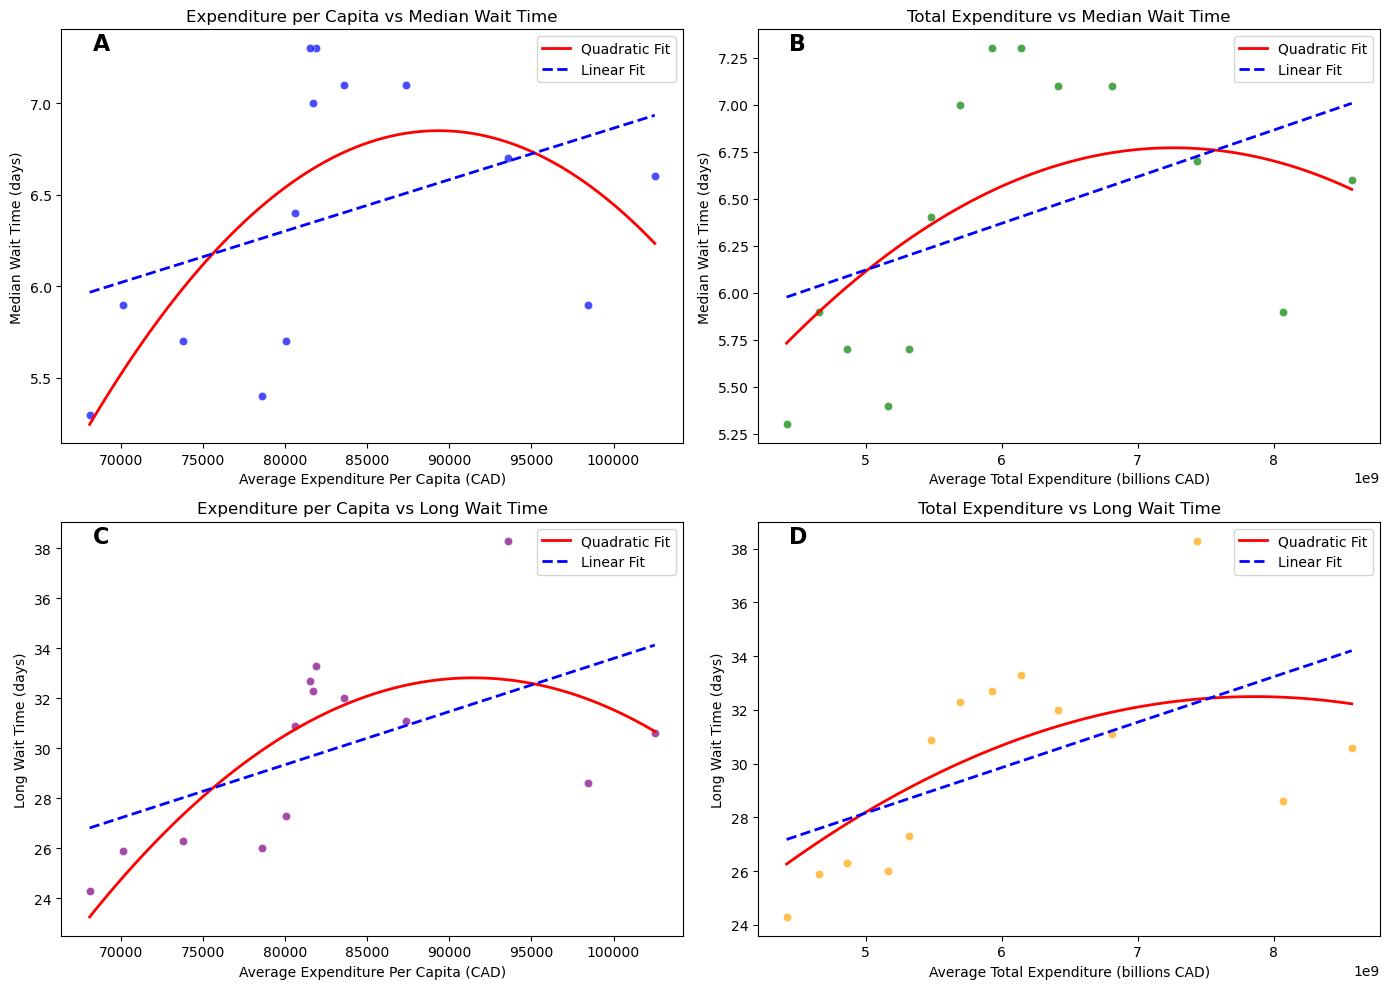

In [27]:
# Define X (predictor) and y (response) for different models
X = df['AVG_EXPENDITURE_PER_CAPITA'].values.flatten()

# Prepare data for each model (median and long wait times)
y_median = df['MEDIAN_WAIT_TIME'].values
y_long = df['LONG_WAIT_TIME'].values

# Quadratic Regression Model Function
def quadratic_regression(X, y):
    X_squared = X ** 2
    X_quad = np.column_stack((X, X_squared))
    X_quad = sm.add_constant(X_quad)  # Add intercept
    model = sm.OLS(y, X_quad).fit()
    return model

# Linear Regression Model Function
def linear_regression(X, y):
    X_linear = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X_linear).fit()
    return model

# Fit quadratic models for both responses
model_median = quadratic_regression(X, y_median)
model_long = quadratic_regression(X, y_long)

# Fit linear models for both responses
model_median_linear = linear_regression(X, y_median)
model_long_linear = linear_regression(X, y_long)

# Get predictions from the quadratic models
X_range = np.linspace(X.min(), X.max(), 100)  # Create a smooth range of X values
X_range_squared = X_range ** 2
X_range_quad = sm.add_constant(np.column_stack((X_range, X_range_squared)))

y_pred_median_smooth = model_median.predict(X_range_quad)
y_pred_long_smooth = model_long.predict(X_range_quad)

# Get predictions from the linear models
X_range_linear = sm.add_constant(X_range)  # Add intercept for linear model
y_pred_median_linear = model_median_linear.predict(X_range_linear)
y_pred_long_linear = model_long_linear.predict(X_range_linear)

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Quadratic regression for AVG_EXPENDITURE_PER_CAPITA vs MEDIAN_WAIT_TIME
sns.scatterplot(x=X, y=y_median, ax=axs[0, 0], color='blue', alpha=0.7)
axs[0, 0].plot(X_range, y_pred_median_smooth, color='red', linewidth=2, label='Quadratic Fit')
axs[0, 0].plot(X_range, y_pred_median_linear, color='blue', linewidth=2, linestyle='--', label='Linear Fit')
axs[0, 0].set_title('Expenditure per Capita vs Median Wait Time')
axs[0, 0].set_xlabel('Average Expenditure Per Capita (CAD)')
axs[0, 0].set_ylabel('Median Wait Time (days)')
axs[0, 0].legend()
axs[0, 0].text(0.05, 0.95, 'A', transform=axs[0, 0].transAxes, fontsize=16, fontweight='bold', color='black')

# Plot 2: Quadratic regression for AVG_TOTAL_EXPENDITURE vs MEDIAN_WAIT_TIME
X_total_exp = df['AVG_TOTAL_EXPENDITURE'].values.flatten()
model_median_total = quadratic_regression(X_total_exp, y_median)
model_median_total_linear = linear_regression(X_total_exp, y_median)

X_total_exp_range = np.linspace(X_total_exp.min(), X_total_exp.max(), 100)
X_total_exp_range_squared = X_total_exp_range ** 2
X_total_exp_range_quad = sm.add_constant(np.column_stack((X_total_exp_range, X_total_exp_range_squared)))

y_pred_median_total_smooth = model_median_total.predict(X_total_exp_range_quad)
y_pred_median_total_linear = model_median_total_linear.predict(sm.add_constant(X_total_exp_range))

sns.scatterplot(x=X_total_exp, y=y_median, ax=axs[0, 1], color='green', alpha=0.7)
axs[0, 1].plot(X_total_exp_range, y_pred_median_total_smooth, color='red', linewidth=2, label='Quadratic Fit')
axs[0, 1].plot(X_total_exp_range, y_pred_median_total_linear, color='blue', linewidth=2, linestyle='--', label='Linear Fit')
axs[0, 1].set_title('Total Expenditure vs Median Wait Time')
axs[0, 1].set_xlabel('Average Total Expenditure (billions CAD)')
axs[0, 1].set_ylabel('Median Wait Time (days)')
axs[0, 1].legend()
axs[0, 1].text(0.05, 0.95, 'B', transform=axs[0, 1].transAxes, fontsize=16, fontweight='bold', color='black')

# Plot 3: Quadratic regression for AVG_EXPENDITURE_PER_CAPITA vs LONG_WAIT_TIME
sns.scatterplot(x=X, y=y_long, ax=axs[1, 0], color='purple', alpha=0.7)
axs[1, 0].plot(X_range, y_pred_long_smooth, color='red', linewidth=2, label='Quadratic Fit')
axs[1, 0].plot(X_range, y_pred_long_linear, color='blue', linewidth=2, linestyle='--', label='Linear Fit')
axs[1, 0].set_title('Expenditure per Capita vs Long Wait Time')
axs[1, 0].set_xlabel('Average Expenditure Per Capita (CAD)')
axs[1, 0].set_ylabel('Long Wait Time (days)')
axs[1, 0].legend()
axs[1, 0].text(0.05, 0.95, 'C', transform=axs[1, 0].transAxes, fontsize=16, fontweight='bold', color='black')

# Plot 4: Quadratic regression for AVG_TOTAL_EXPENDITURE vs LONG_WAIT_TIME
model_long_total = quadratic_regression(X_total_exp, y_long)
model_long_total_linear = linear_regression(X_total_exp, y_long)

y_pred_long_total_smooth = model_long_total.predict(X_total_exp_range_quad)
y_pred_long_total_linear = model_long_total_linear.predict(sm.add_constant(X_total_exp_range))

sns.scatterplot(x=X_total_exp, y=y_long, ax=axs[1, 1], color='orange', alpha=0.7)
axs[1, 1].plot(X_total_exp_range, y_pred_long_total_smooth, color='red', linewidth=2, label='Quadratic Fit')
axs[1, 1].plot(X_total_exp_range, y_pred_long_total_linear, color='blue', linewidth=2, linestyle='--', label='Linear Fit')
axs[1, 1].set_title('Total Expenditure vs Long Wait Time')
axs[1, 1].set_xlabel('Average Total Expenditure (billions CAD)')
axs[1, 1].set_ylabel('Long Wait Time (days)')
axs[1, 1].legend()
axs[1, 1].text(0.05, 0.95, 'D', transform=axs[1, 1].transAxes, fontsize=16, fontweight='bold', color='black')

plt.tight_layout()
plt.show()